In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Input
from tensorflow.keras.layers import Flatten, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
import keras_tuner as kt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# loading the IMDB dataset
path_ds = "/content/drive/MyDrive/TXSA_Assignment/cleaned_IMDB_Dataset.csv"
df = pd.read_csv(path_ds)
print(df.shape)

(50000, 2)


# EDA

## Get word counts

Positive reviews: 
count    25000.000000
mean       119.733200
std         92.993219
min          6.000000
25%         62.000000
50%         88.000000
75%        146.000000
max       1418.000000
Name: review, dtype: float64
Negative reviews: 
count    25000.000000
mean       116.450720
std         84.708678
min          3.000000
25%         64.000000
50%         88.000000
75%        141.000000
max        802.000000
Name: review, dtype: float64


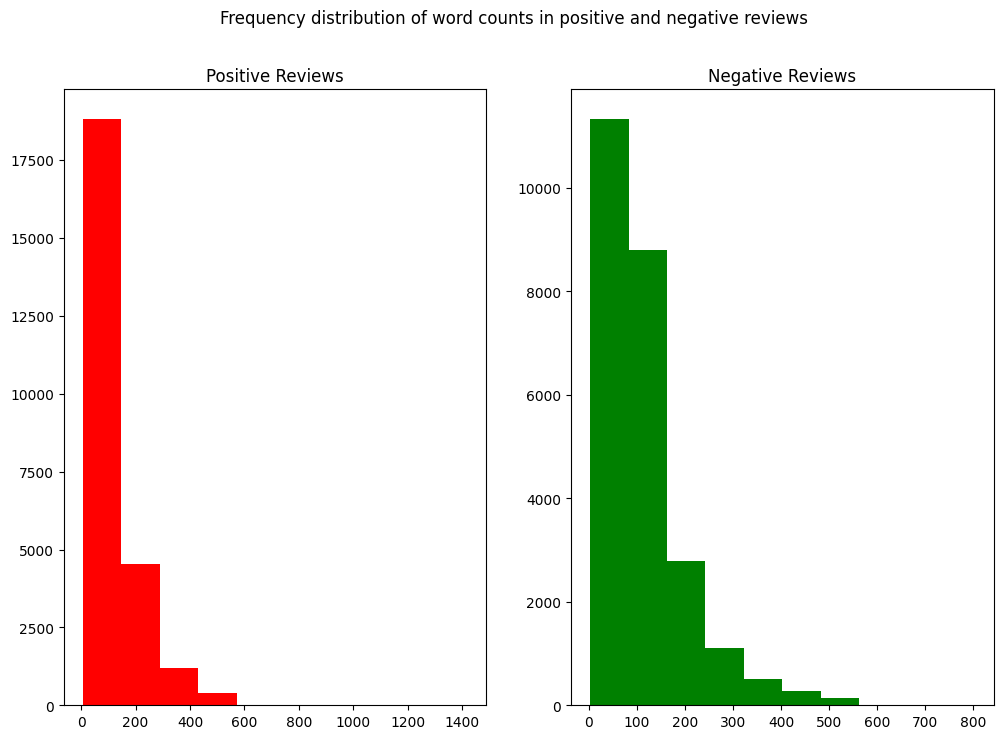

In [ ]:
# Number of words in each text/review
# Knowing this can define max sequence length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
word_counts_pos = df[df['sentiment']=="positive"]['review'].str.split().map(lambda x: len(x))
print("Positive reviews: ")
print(word_counts_pos.describe())
ax1.hist(word_counts_pos,color='red')
ax1.set_title('Positive Reviews')

word_counts_neg = df[df['sentiment']=="negative"]['review'].str.split().map(lambda x: len(x))
print("Negative reviews: ")
print(word_counts_neg.describe())
ax2.hist(word_counts_neg,color='green')
ax2.set_title('Negative Reviews')
fig.suptitle('Frequency distribution of word counts in positive and negative reviews')
plt.show()

## Get number of vocabularies

In [ ]:
# Knowing this can decide number of vocabs
tk_ds = Tokenizer()
tk_ds.fit_on_texts(df["review"])
print("Number of unique words (vocabularies) in whole dataset = ", len(tk_ds.word_index))

Number of unique words (vocabularies) in whole dataset =  193030


# Processing Dataset

In [ ]:
# indicating positive reviews as 1, negative reviews as 0
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
X = df.review
y = df.sentiment


# `stratify` to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array
x_train, x_test, y_train,y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state= 0,
    stratify= y
)
print('X_train shape --> ', x_train.shape)
print('y_train shape --> ', y_train.shape)
print('X_test shape --> ', x_test.shape)
print('y_test shape --> ', y_test.shape)

X_train shape -->  (40000,)
y_train shape -->  (40000,)
X_test shape -->  (10000,)
y_test shape -->  (10000,)


In [ ]:
max_sequence_len = 150
vocab_num = 5000

word_tokenizer = Tokenizer(num_words=vocab_num, oov_token="<OOV>")
word_tokenizer.fit_on_texts(x_train)

# converting text data into sequences of not uniform lengths
X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

# pad or truncate the sequences to achieve uniform lengths according to `max_sequence_len`
X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_sequence_len)

In [ ]:
# Defining a function to visualize the model loss and model accuracy
import matplotlib.pyplot as plt
def plot_accuracies_losses(history, optimizer_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Model accuracy using optimizer ' + optimizer_name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model loss using optimizer ' + optimizer_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

# Building LSTM with SGD

In [ ]:
def model_builder_sgd(hp):
    # ranges of hyperparams
    hp_embedding_dim = hp.Int("embedding_dim", min_value=300, max_value=500, step=100)
    hp_hidden_unit_dim = hp.Int("hidden_unit_dim", min_value=32, max_value=128, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_momentum = hp.Choice("momentum", values=[0.0, 0.5, 0.9, 0.99])

    # defining model architecture
    model = Sequential()
    model.add(Embedding(vocab_num, hp_embedding_dim, input_length=max_sequence_len))
    model.add(LSTM(hp_hidden_unit_dim))
    model.add(Dense(1, activation='sigmoid'))
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        hp_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )
    sgd_opt = keras.optimizers.SGD(
        learning_rate=lr_schedule,
        momentum=hp_momentum
    )

    # compiling the model with SGD optimizer, binary crossentropy as the loss function, accuracy as the evaluation metric
    model.compile(
        optimizer=sgd_opt,
        loss="binary_crossentropy",
        metrics=['accuracy']
    )

    return model

In [ ]:
# early stopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# grid search for hyperparam tuning
tuner = kt.GridSearch(
    model_builder_sgd,
    objective='val_accuracy',
    directory='GridSearchResults',
    project_name='LSTM_SGD',
)

EPOCH_NUM = 30

tuner.search(X_train, y_train, epochs=EPOCH_NUM, validation_data=(X_test, y_test), callbacks=[stop_early])

Trial 10 Complete [00h 07m 50s]
val_accuracy: 0.5077999830245972

Best val_accuracy So Far: 0.8790000081062317
Total elapsed time: 01h 02m 12s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
300               |300               |embedding_dim
32                |32                |hidden_unit_dim
0.0001            |0.01              |learning_rate
0.9               |0.99              |momentum

Epoch 1/30
1250/1250 [==============================] - 16s 12ms/step - loss: 0.6937 - accuracy: 0.4922 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 2/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6933 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/30
1250/1250 [==============================] - 17s 13ms/step - loss: 0.6933 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 4/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_acc

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
The hyperparameter search is complete.
The optimal dimension of embedding vector is {best_hps.get('embedding_dim')}
The optimal dimension of hidden units in LSTM layer is {best_hps.get('hidden_unit_dim')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}
The optimal momentum for the optimizer is {best_hps.get('momentum')}
""")

Best set of hyperparameters for SGD optimizer: <br>
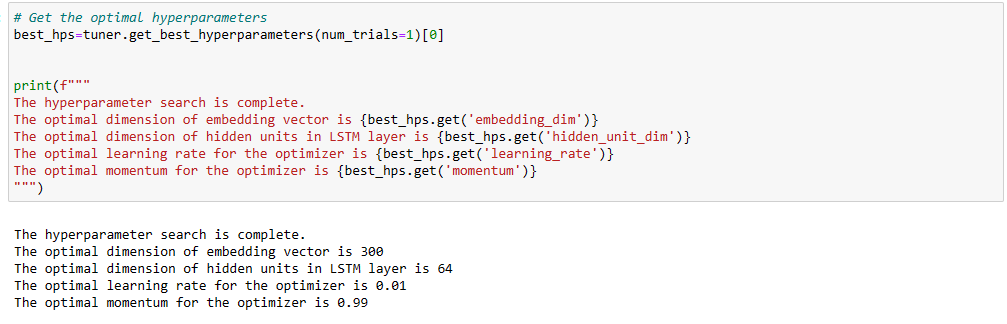

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

val_acc_per_epoch = history.history['val_acc']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
plot_accuracies_losses(history, "SGD")

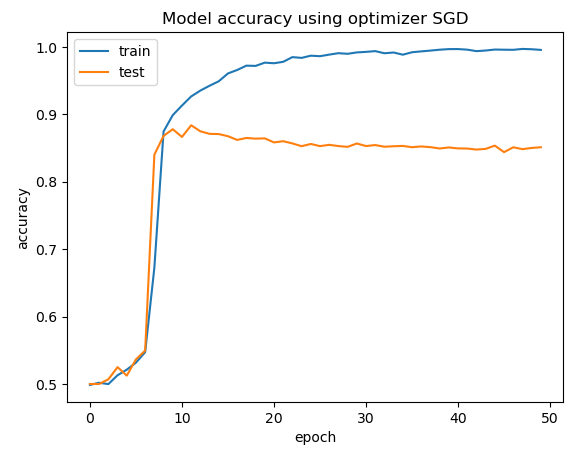

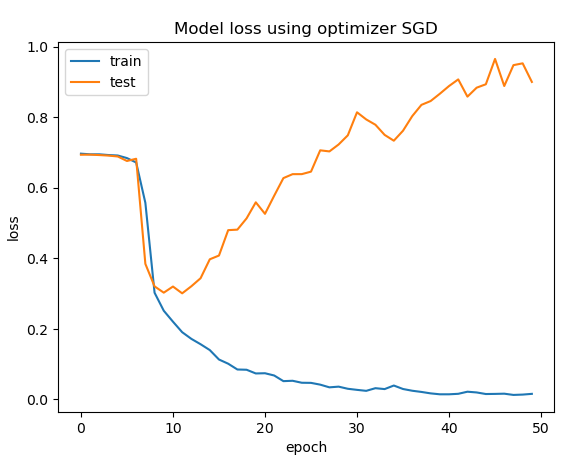

# Evaluating the model with best set of hyperparameters

In [ ]:
# rebuilding and retraining the model with the best set of hyperparams
model = Sequential()
model.add(Embedding(vocab_num, 300, input_length=max_sequence_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
sgd_opt = keras.optimizers.SGD(
    learning_rate=lr_schedule,
    momentum=0.99
)

model.compile(
    optimizer=sgd_opt,
    loss="binary_crossentropy",
    metrics=['accuracy']
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
EPOCH_NUM = 30

history = model.fit(X_train, y_train, epochs=EPOCH_NUM, validation_data=(X_test, y_test), callbacks=[stop_early])

Epoch 1/30
1250/1250 [==============================] - 43s 32ms/step - loss: 0.6947 - accuracy: 0.5031 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 2/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6955 - accuracy: 0.5019 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/30
1250/1250 [==============================] - 13s 11ms/step - loss: 0.6949 - accuracy: 0.5013 - val_loss: 0.6922 - val_accuracy: 0.5227
Epoch 4/30
1250/1250 [==============================] - 17s 13ms/step - loss: 0.6935 - accuracy: 0.5153 - val_loss: 0.6904 - val_accuracy: 0.5133
Epoch 5/30
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6914 - accuracy: 0.5206 - val_loss: 0.7046 - val_accuracy: 0.5248
Epoch 6/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6855 - accuracy: 0.5329 - val_loss: 0.7019 - val_accuracy: 0.5162
Epoch 7/30
1250/1250 [==============================] - 12s 10ms/step - loss: 0.6780 - accuracy: 0.5389 - val_loss: 0.7004 -

In [ ]:
# Save the weights

model.save_weights('/content/drive/MyDrive/TXSA_Assignment/LSTM_params')

In [ ]:
# Restore the weights
model.load_weights('/content/drive/MyDrive/TXSA_Assignment/LSTM_params')

# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 7s - loss: 0.4176 - accuracy: 0.8647 - 7s/epoch - 23ms/step
Restored model, accuracy: 86.47%


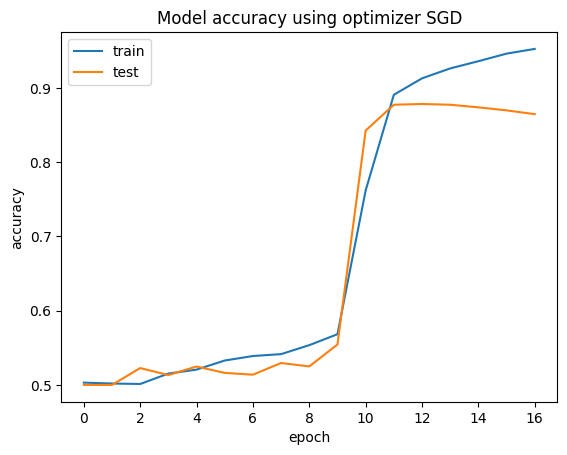

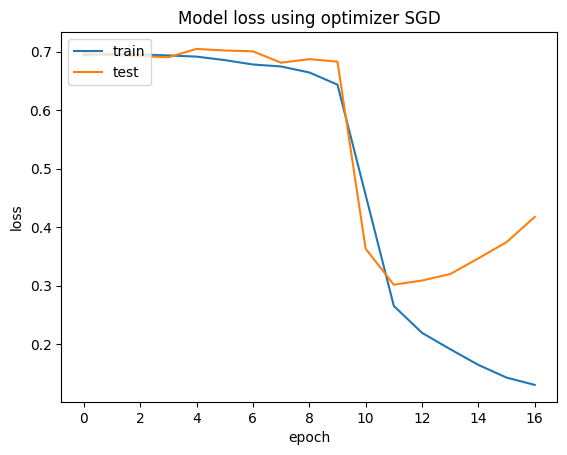

In [ ]:
plot_accuracies_losses(history, "SGD")

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train = np.where(y_pred_train >= 0.5, 1, 0)
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

313/313 [==============================] - 2s 5ms/step


In [ ]:
from tensorflow.math import confusion_matrix
import seaborn as sns

In [ ]:
def plot_confusion_matrix(actual, predicted, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    print(cm)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(5, 5)})
    sns.set(font_scale=1.0)
    ax.set_title('Confusion matrix of sentiment analysis for ' + ds_type)
    ax.set_xlabel('Predicted Sentiment')
    ax.set_ylabel('Actual Sentiment')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

tf.Tensor(
[[19634   366]
 [  854 19146]], shape=(2, 2), dtype=int32)


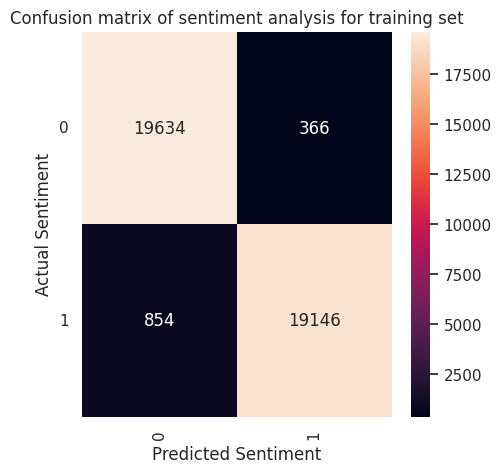

In [ ]:
plot_confusion_matrix(y_train, y_pred_train, "training set")

tf.Tensor(
[[4425  575]
 [ 778 4222]], shape=(2, 2), dtype=int32)


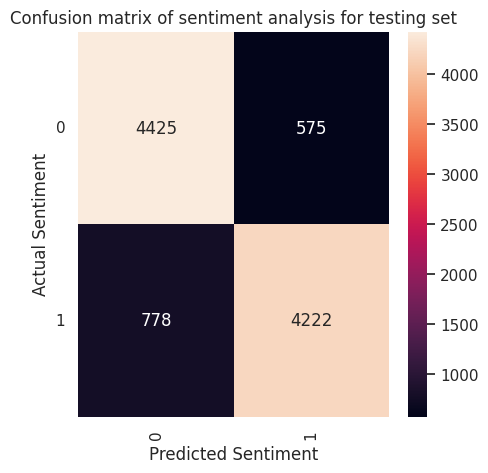

In [ ]:
plot_confusion_matrix(y_test, y_pred_test, "testing set")

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Train accuracy: {:5.2f}%".format(100 * train_acc))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))

1250/1250 - 4s - loss: 0.0908 - accuracy: 0.9695 - 4s/epoch - 3ms/step
313/313 - 2s - loss: 0.4176 - accuracy: 0.8647 - 2s/epoch - 5ms/step
Train accuracy: 96.95%
Test accuracy: 86.47%
